In [2]:
# Step 1: Load Required Libraries
!pip install pmdarima # Install pmdarima package

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima # Now you can import pmdarima
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:00


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [115]:
!pip install --upgrade numpy
!pip install --upgrade pmdarima

In [116]:
# Step 2: Load and View Dataset
fuel_df = pd.read_excel("original_fuel_price_dataset.xlsx")

# Step 2a: Preview data structure
print(fuel_df.info())
print(fuel_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   week_ending          214 non-null    datetime64[ns]
 1   avg_fuel_price       212 non-null    float64       
 2   qty_per_transaction  212 non-null    float64       
 3   avg_road_fuel_sales  212 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 6.8+ KB
None
  week_ending  avg_fuel_price  qty_per_transaction avg_road_fuel_sales
0  2021-01-31       92.609795            97.202065           65.756879
1  2021-02-07       94.467352            95.448788           67.471288
2  2021-02-14       95.851356            95.891945           67.300106
3  2021-02-21       97.410857            92.916855           69.005771
4  2021-02-28       98.312732            92.083632           69.591091


In [117]:
fuel_df.columns = fuel_df.columns.str.strip().str.lower()
print(fuel_df.columns)


Index(['week_ending', 'avg_fuel_price', 'qty_per_transaction',
       'avg_road_fuel_sales'],
      dtype='object')


In [118]:
# Clean and print exact column names
fuel_df.columns = fuel_df.columns.str.strip().str.lower()
print(fuel_df.columns.tolist())


['week_ending', 'avg_fuel_price', 'qty_per_transaction', 'avg_road_fuel_sales']


In [119]:
import pandas as pd

# Upload file
from google.colab import files
uploaded = files.upload()

# Load and preview dataset
fuel_df = pd.read_excel("original_fuel_price_dataset.xlsx")
fuel_df.columns = fuel_df.columns.str.strip().str.lower()
print(fuel_df.columns.tolist())
fuel_df.head()


Saving original_fuel_price_dataset.xlsx to original_fuel_price_dataset (2).xlsx
['week_ending', 'avg_fuel_price', 'qty_per_transaction', 'avg_road_fuel_sales']


,week_ending,avg_fuel_price,qty_per_transaction,avg_road_fuel_sales
0,2021-01-31,92.609795,97.202065,65.756879
1,2021-02-07,94.467352,95.448788,67.471288
2,2021-02-14,95.851356,95.891945,67.300106
3,2021-02-21,97.410857,92.916855,69.005771
4,2021-02-28,98.312732,92.083632,69.591091


In [120]:
# Step 3a: Clean column names only once
fuel_df.columns = fuel_df.columns.str.strip().str.lower()

# Step 3b: Reset index if needed to access 'week_ending'
if 'week_ending' not in fuel_df.columns:
    fuel_df = fuel_df.reset_index()

# Step 3c: Convert to datetime
fuel_df['week_ending'] = pd.to_datetime(fuel_df['week_ending'])

# Step 3d: Set as index
fuel_df.set_index('week_ending', inplace=True)

# Step 3e: Drop duplicate dates
fuel_df = fuel_df[~fuel_df.index.duplicated(keep='first')]

# Step 3f: Set frequency to weekly
fuel_df = fuel_df.asfreq('W')


In [121]:
# Step 4a: Check for missing values
missing_counts = fuel_df.isnull().sum()
print("Missing values per column:\n", missing_counts)

# Step 4b: Handle missing values (linear interpolation)
fuel_df.interpolate(method='linear', inplace=True)

# Step 4c: Confirm no missing values remain
print("\nMissing values after interpolation:\n", fuel_df.isnull().sum())


Missing values per column:
 avg_fuel_price         2
qty_per_transaction    2
avg_road_fuel_sales    2
dtype: int64

Missing values after interpolation:
 avg_fuel_price         0
qty_per_transaction    0
avg_road_fuel_sales    2
dtype: int64


<ipython-input-121-871ff8f57fa8>:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  fuel_df.interpolate(method='linear', inplace=True)


In [122]:
# Step 4d: Convert avg_road_fuel_sales to numeric, forcing invalid entries to NaN
fuel_df['avg_road_fuel_sales'] = pd.to_numeric(fuel_df['avg_road_fuel_sales'], errors='coerce')

# Step 4e: Interpolate again
fuel_df['avg_road_fuel_sales'] = fuel_df['avg_road_fuel_sales'].interpolate(method='linear')

# Step 4f: Final check
print("Final missing values:\n", fuel_df.isnull().sum())


Final missing values:
 avg_fuel_price         0
qty_per_transaction    0
avg_road_fuel_sales    0
dtype: int64


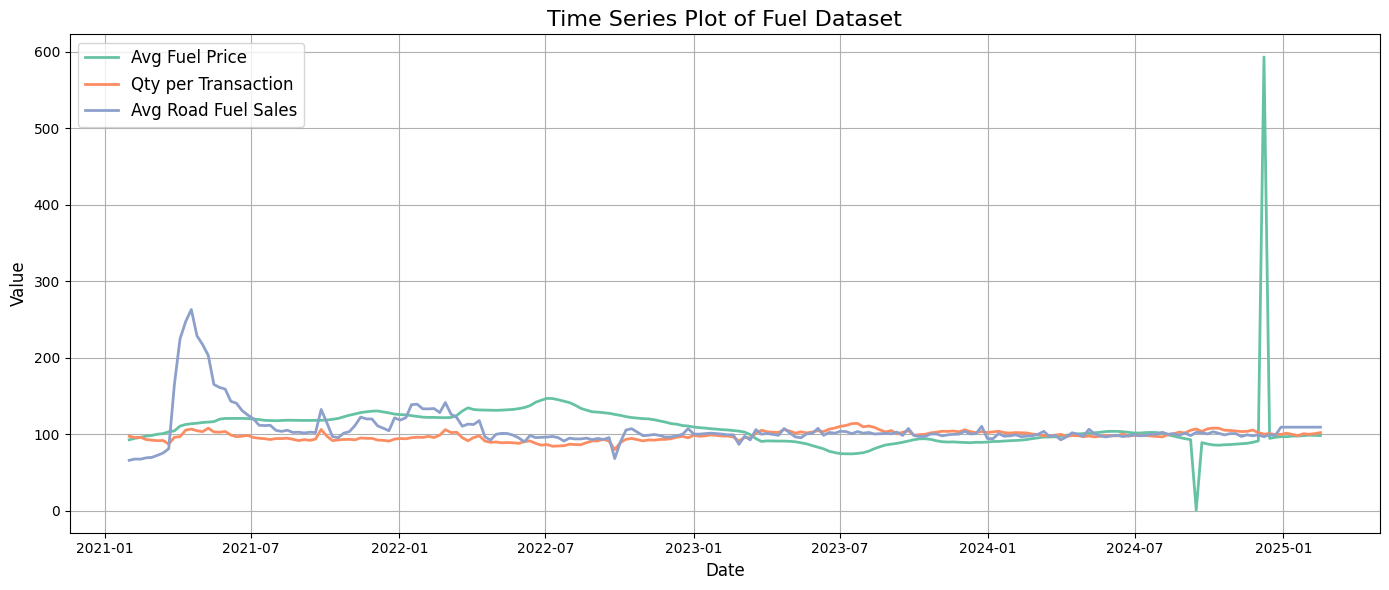

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 6a: Use seaborn color palette
colors = sns.color_palette("Set2")

# Step 6b: Create plot
plt.figure(figsize=(14, 6))
plt.plot(fuel_df.index, fuel_df['avg_fuel_price'], label='Avg Fuel Price', color=colors[0], linewidth=2)
plt.plot(fuel_df.index, fuel_df['qty_per_transaction'], label='Qty per Transaction', color=colors[1], linewidth=2)
plt.plot(fuel_df.index, fuel_df['avg_road_fuel_sales'], label='Avg Road Fuel Sales', color=colors[2], linewidth=2)

# Step 6c: Final layout
plt.title("Time Series Plot of Fuel Dataset", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


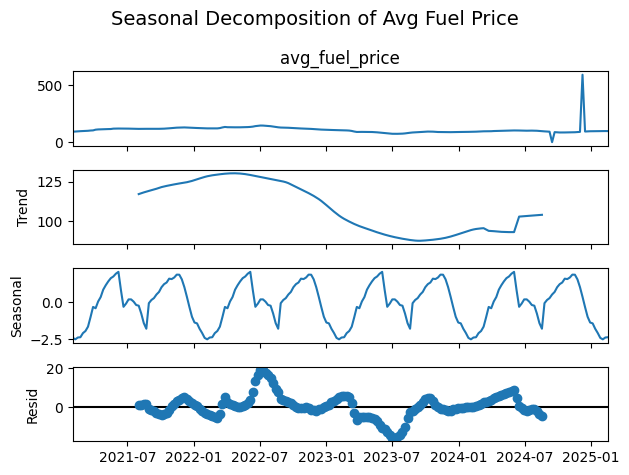

In [124]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 7: Decompose with additive model
result = seasonal_decompose(fuel_df['avg_fuel_price'], model='additive', period=52)  # 52 weeks ~ yearly seasonality
result.plot()
plt.suptitle("Seasonal Decomposition of Avg Fuel Price", fontsize=14)
plt.tight_layout()
plt.show()


In [125]:
from statsmodels.tsa.stattools import adfuller

# Step 8a: Drop NaNs (required for ADF test)
series = fuel_df['avg_fuel_price'].dropna()

# Step 8b: Perform ADF test
adf_result = adfuller(series)

# Step 8c: Display results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Step 8d: Interpret result
if adf_result[1] <= 0.05:
    print("\n✅ The series is stationary (reject H0)")
else:
    print("\n❌ The series is non-stationary (fail to reject H0)")


ADF Statistic: -0.8521957011452378
p-value: 0.8033073792406169
Critical Values:
   1%: -3.464161278384219
   5%: -2.876401960790147
   10%: -2.5746921001665974

❌ The series is non-stationary (fail to reject H0)


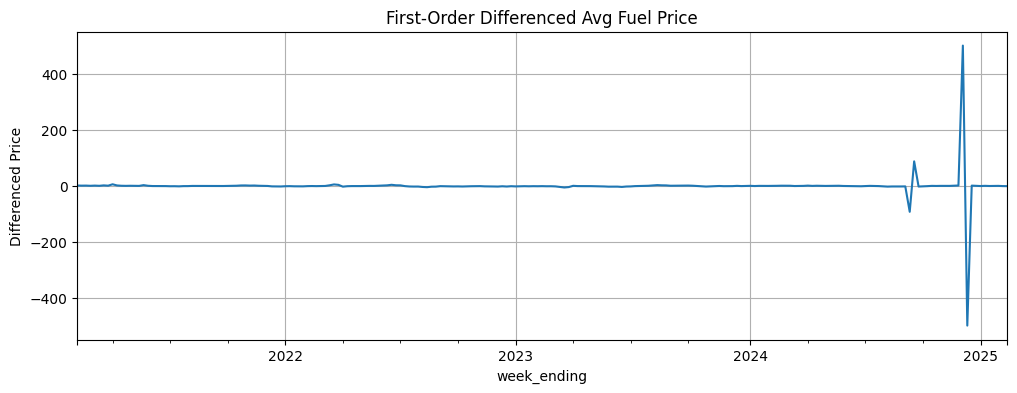

In [126]:
# Step 9a: First-order differencing
fuel_df['avg_fuel_price_diff'] = fuel_df['avg_fuel_price'].diff()

# Step 9b: Visualise the differenced series
fuel_df['avg_fuel_price_diff'].dropna().plot(figsize=(12, 4), title="First-Order Differenced Avg Fuel Price")
plt.ylabel("Differenced Price")
plt.grid(True)
plt.show()


In [127]:
# Step 9c: ADF test on differenced series
diff_series = fuel_df['avg_fuel_price_diff'].dropna()
adf_result_diff = adfuller(diff_series)

print("ADF Statistic (Differenced):", adf_result_diff[0])
print("p-value:", adf_result_diff[1])
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"   {key}: {value}")

if adf_result_diff[1] <= 0.05:
    print("\n✅ The differenced series is now stationary (reject H0)")
else:
    print("\n❌ The differenced series is still non-stationary")


ADF Statistic (Differenced): -4.91403949069143
p-value: 3.2745072552359613e-05
Critical Values:
   1%: -3.464161278384219
   5%: -2.876401960790147
   10%: -2.5746921001665974

✅ The differenced series is now stationary (reject H0)


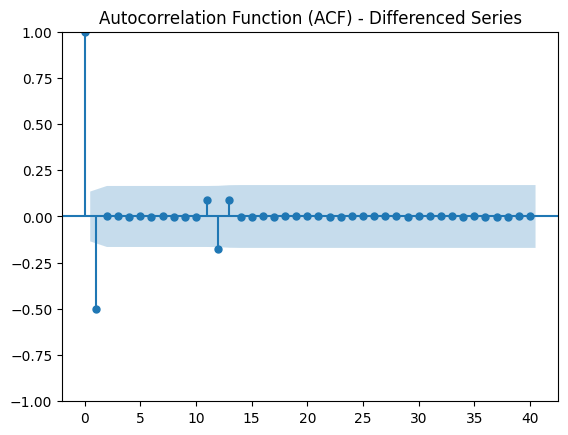

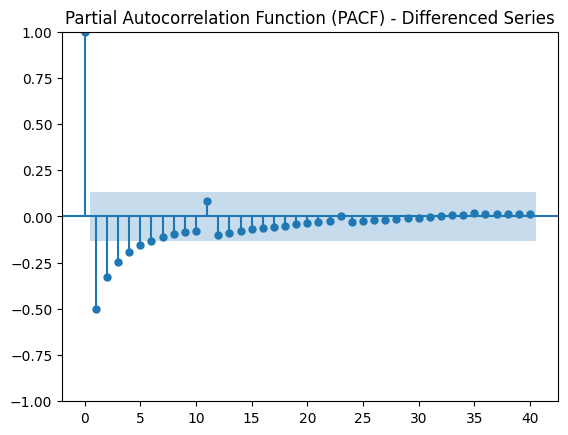

In [128]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 10a: ACF plot (to determine MA(q) component)
plot_acf(fuel_df['avg_fuel_price_diff'].dropna(), lags=40)
plt.title("Autocorrelation Function (ACF) - Differenced Series")
plt.show()

# Step 10b: PACF plot (to determine AR(p) component)
plot_pacf(fuel_df['avg_fuel_price_diff'].dropna(), lags=40)
plt.title("Partial Autocorrelation Function (PACF) - Differenced Series")
plt.show()


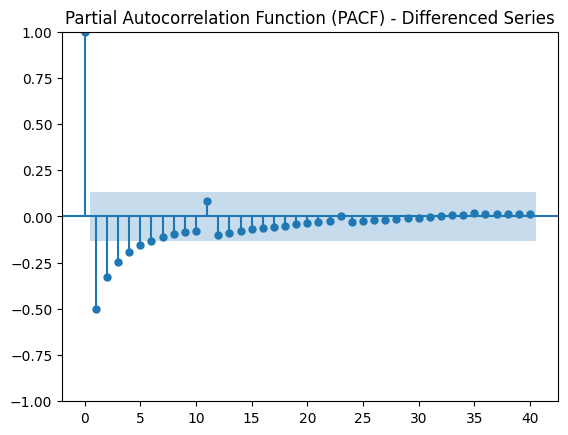

In [129]:
plot_pacf(fuel_df['avg_fuel_price_diff'].dropna(), lags=40)
plt.title("Partial Autocorrelation Function (PACF) - Differenced Series")
plt.show()


In [131]:
# Step 11: Train-Test Split (Univariate target: avg_fuel_price)
train_size = int(len(fuel_df) * 0.8)
train = fuel_df['avg_fuel_price'].iloc[:train_size]
test = fuel_df['avg_fuel_price'].iloc[train_size:]

# Optional: check sizes
print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")


Train size: 169
Test size: 43


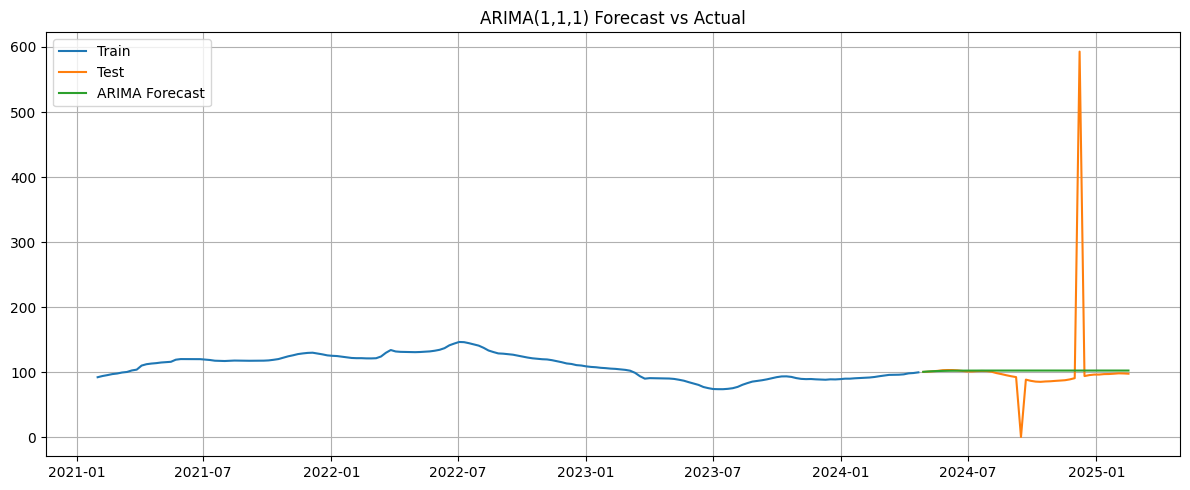

In [132]:
from statsmodels.tsa.arima.model import ARIMA

# Step 12a: Fit ARIMA(1,1,1) on training data
model_arima = ARIMA(train, order=(1, 1, 1))
model_arima_fit = model_arima.fit()

# Step 12b: Forecast on test period
forecast_arima = model_arima_fit.forecast(steps=len(test))

# Step 12c: Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.title("ARIMA(1,1,1) Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [133]:
# Step 12d1: Import evaluation tools
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 12d2: Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(test, forecast_arima)

# Step 12d3: Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(test, forecast_arima))  # compatible with older sklearn

# Step 12d4: Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((test - forecast_arima) / test)) * 100

# Step 12d5: Print results
print("Step 12d: ARIMA(1,1,1) Forecast Accuracy:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


Step 12d: ARIMA(1,1,1) Forecast Accuracy:
MAE  : 20.12
RMSE : 76.83
MAPE : 323.97%


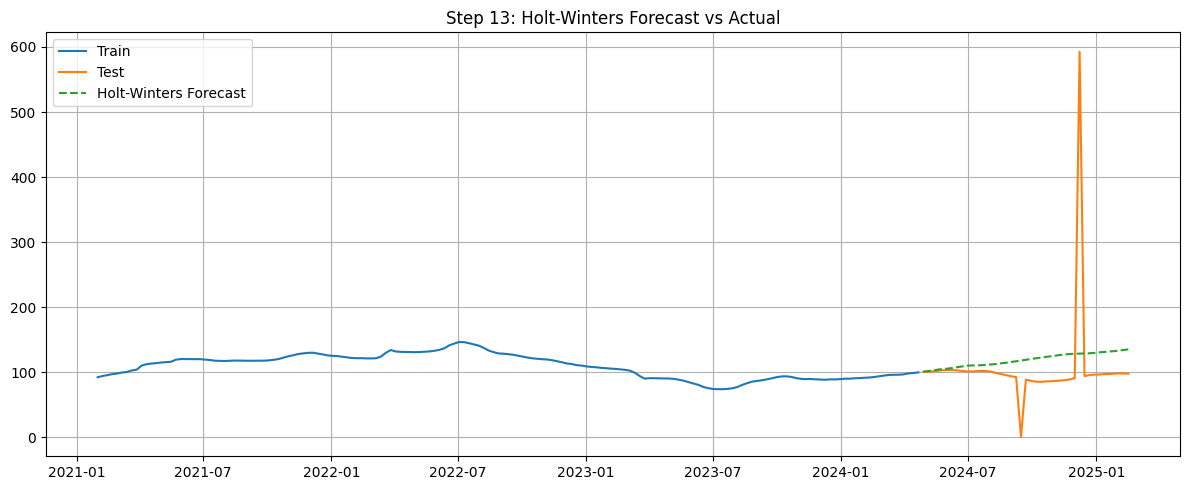

In [134]:
# Step 13a: Import the model
from statsmodels.tsa.api import ExponentialSmoothing

# Step 13b: Fit the Holt-Winters model (additive trend and seasonality)
# 'seasonal_periods=52' because this is weekly data with yearly seasonality
hw_model = ExponentialSmoothing(train,
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=52).fit()

# Step 13c: Forecast for the length of the test set
hw_forecast = hw_model.forecast(len(test))

# Step 13d: Plot the Holt-Winters forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', linestyle='--')
plt.title("Step 13: Holt-Winters Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [135]:
# Step 13e1: Calculate MAE
mae_hw = mean_absolute_error(test, hw_forecast)

# Step 13e2: Calculate RMSE
rmse_hw = np.sqrt(mean_squared_error(test, hw_forecast))

# Step 13e3: Calculate MAPE
mape_hw = np.mean(np.abs((test - hw_forecast) / test)) * 100

# Step 13e4: Print results
print("Step 13e: Holt-Winters Forecast Accuracy:")
print(f"MAE  : {mae_hw:.2f}")
print(f"RMSE : {rmse_hw:.2f}")
print(f"MAPE : {mape_hw:.2f}%")


Step 13e: Holt-Winters Forecast Accuracy:
MAE  : 35.16
RMSE : 77.59
MAPE : 387.68%


In [136]:
# Step P1–P3 (same as before)
import pandas as pd

merged_df = pd.read_csv("/content/merged_fuel_brent_dataset.csv")
merged_df.columns = merged_df.columns.str.strip().str.lower()
merged_df['week_ending'] = pd.to_datetime(merged_df['week_ending'])
merged_df.set_index('week_ending', inplace=True)

# ✅ Step P3.5: Remove duplicate date entries
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# Step P4: Set weekly frequency
merged_df = merged_df.asfreq('W')

# Step P5: Interpolate missing values if needed
merged_df.interpolate(method='linear', inplace=True)

# Step P6: Confirm structure
print(merged_df.columns)
merged_df.head()


Index(['avg_fuel_price', 'qty_per_transaction', 'avg_road_fuel_sales',
       'brent_price'],
      dtype='object')


<ipython-input-136-7ef53b042ad8>:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  merged_df.interpolate(method='linear', inplace=True)


,avg_fuel_price,qty_per_transaction,avg_road_fuel_sales,brent_price
week_ending,,,,
2021-01-31,92.609795,97.202065,65.7568794,55.178
2021-02-07,94.467352,95.448788,67.471288,58.222
2021-02-14,95.851356,95.891945,67.3001064,61.128
2021-02-21,97.410857,92.916855,69.0057712,63.898
2021-02-28,98.312732,92.083632,69.5910914,65.858


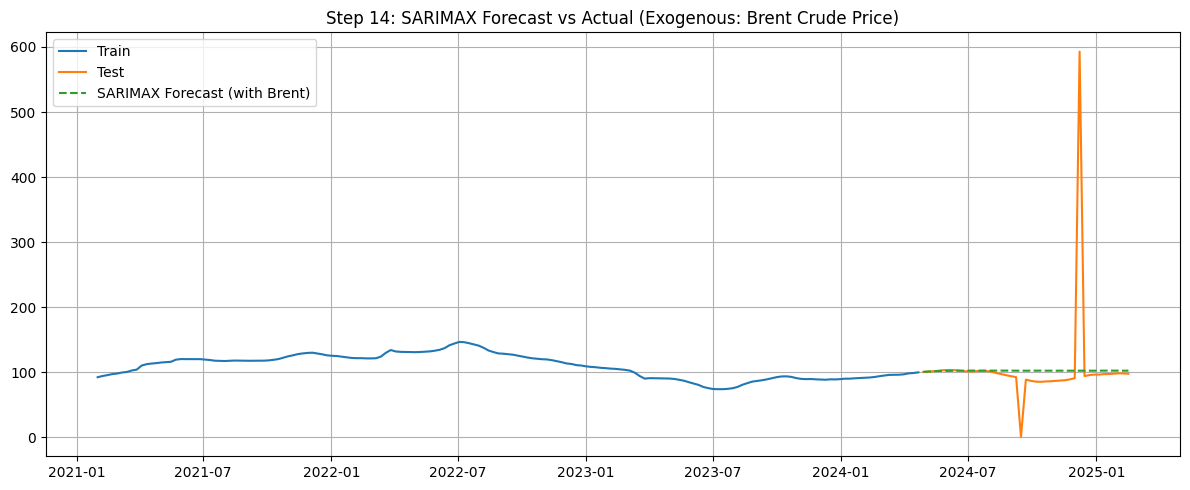

In [138]:
# Step 14a: Define target and exogenous variables
target = merged_df['avg_fuel_price']
exog = merged_df['brent_price']

# Step 14b: Train-test split (80/20)
train_size = int(len(target) * 0.8)
train = target.iloc[:train_size]
test = target.iloc[train_size:]
exog_train = exog.iloc[:train_size]
exog_test = exog.iloc[train_size:]

# Step 14c: Fit SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(train,
                        exog=exog_train,
                        order=(1, 1, 1),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()

# Step 14d: Forecast and plot
sarimax_forecast = sarimax_model.forecast(steps=len(test), exog=exog_test)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast (with Brent)', linestyle='--')
plt.title("Step 14: SARIMAX Forecast vs Actual (Exogenous: Brent Crude Price)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [139]:
# Step 14e1: Calculate MAE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_sarimax_brent = mean_absolute_error(test, sarimax_forecast)

# Step 14e2: Calculate RMSE
rmse_sarimax_brent = np.sqrt(mean_squared_error(test, sarimax_forecast))

# Step 14e3: Calculate MAPE
mape_sarimax_brent = np.mean(np.abs((test - sarimax_forecast) / test)) * 100

# Step 14e4: Print results
print("Step 14e: SARIMAX Forecast Accuracy (with Brent Crude):")
print(f"MAE  : {mae_sarimax_brent:.2f}")
print(f"RMSE : {rmse_sarimax_brent:.2f}")
print(f"MAPE : {mape_sarimax_brent:.2f}%")


Step 14e: SARIMAX Forecast Accuracy (with Brent Crude):
MAE  : 20.02
RMSE : 76.84
MAPE : 323.07%


In [140]:
# Step 15a1: Select relevant columns
var_df = merged_df[['avg_fuel_price', 'brent_price', 'qty_per_transaction']].copy()

# Step 15a2: Ensure no missing values
var_df.dropna(inplace=True)


In [141]:
# Step 15b: 80/20 split
train_size = int(len(var_df) * 0.8)
var_train = var_df.iloc[:train_size]
var_test = var_df.iloc[train_size:]


In [143]:
from statsmodels.tsa.api import VAR

# Step 15c: Fit VAR using optimal lag (based on AIC)
var_model = VAR(var_train)
var_model_fitted = var_model.fit(maxlags=15, ic='aic')

# View model summary
print(var_model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, May, 2025
Time:                     13:47:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    5.41206
Nobs:                     166.000    HQIC:                   5.07793
Log likelihood:          -1079.15    FPE:                    127.752
AIC:                      4.84965    Det(Omega_mle):         107.190
--------------------------------------------------------------------
Results for equation avg_fuel_price
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -3.005156         3.116330           -0.964           0.335
L1.avg_fuel_price              1.750463         0.079032           22.149           0.000
L1.brent_price 

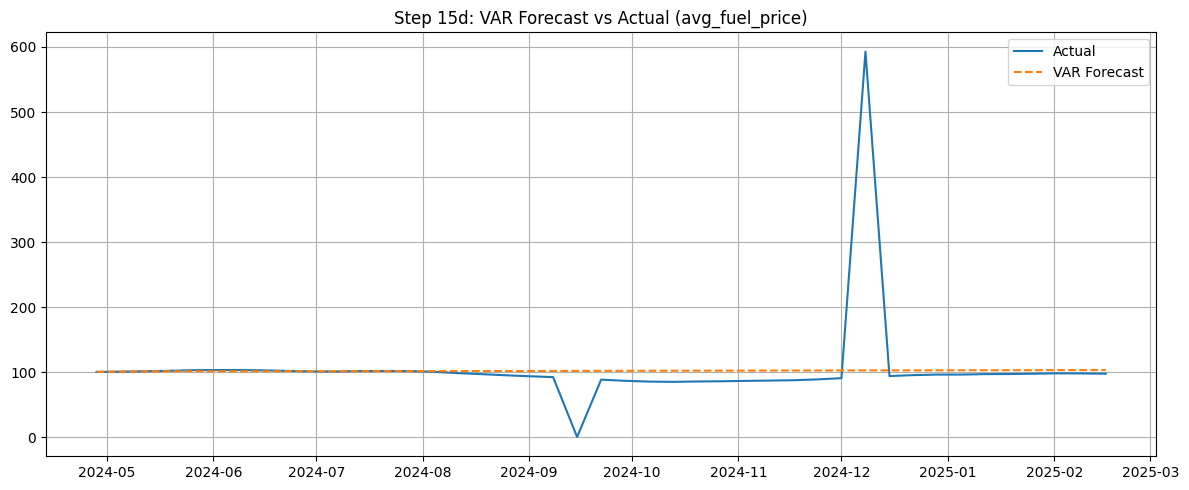

In [60]:
# Step 15d1: Forecast the test period
forecast_input = var_train.values[-var_model_fitted.k_ar:]
var_forecast = var_model_fitted.forecast(y=forecast_input, steps=len(var_test))

# Step 15d2: Convert forecast to DataFrame
var_forecast_df = pd.DataFrame(var_forecast, index=var_test.index, columns=var_test.columns)

# Step 15d3: Plot actual vs forecast for avg_fuel_price
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(var_test['avg_fuel_price'], label='Actual')
plt.plot(var_forecast_df['avg_fuel_price'], label='VAR Forecast', linestyle='--')
plt.title("Step 15d: VAR Forecast vs Actual (avg_fuel_price)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [147]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 15e1: Extract forecast and actual avg_fuel_price
y_pred = var_forecast_df['avg_fuel_price']
y_true = var_test['avg_fuel_price']

# Step 15e2: Calculate metrics
mae_var = mean_absolute_error(y_true, y_pred)
rmse_var = np.sqrt(mean_squared_error(y_true, y_pred))
mape_var = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Step 15e3: Print results
print("Step 15e: VAR Forecast Accuracy (avg_fuel_price only):")
print(f"MAE  : {mae_var:.2f}")
print(f"RMSE : {rmse_var:.2f}")
print(f"MAPE : {mape_var:.2f}%")


Step 15e: VAR Forecast Accuracy (avg_fuel_price only):
MAE  : 20.08
RMSE : 76.78
MAPE : 322.33%


In [148]:
import pandas as pd
fuel_df = pd.read_excel("original_fuel_price_dataset.xlsx")
brent_df = pd.read_excel("Brent crude oil weekly dataset.xls")

In [149]:
fuel_df.columns = ['week_ending', 'avg_fuel_price', 'qty_per_transaction', 'avg_road_fuel_sales']
brent_df = brent_df.rename(columns={
    'Unnamed: 0': 'week_ending',
    'Europe Brent Spot Price FOB (Dollars per Barrel)': 'brent_price'
})

In [156]:
fuel_df.interpolate(method='linear', inplace=True)
brent_df.interpolate(method='linear', inplace=True)

<ipython-input-156-b909488fcb59>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  fuel_df.interpolate(method='linear', inplace=True)
<ipython-input-156-b909488fcb59>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  brent_df.interpolate(method='linear', inplace=True)


In [157]:
fuel_df.drop_duplicates(subset='week_ending', inplace=True)
brent_df.drop_duplicates(subset='week_ending', inplace=True)

In [163]:
merged_df = pd.merge(fuel_df, brent_df, on='week_ending', how='inner')

In [159]:
import pandas as pd

fuel_df = pd.read_excel("original_fuel_price_dataset.xlsx")
brent_df = pd.read_excel("Brent crude oil weekly dataset.xls")

fuel_df.columns = ['week_ending', 'avg_fuel_price', 'qty_per_transaction', 'avg_road_fuel_sales']
brent_df = brent_df.rename(columns={
    'Unnamed: 0': 'week_ending',
    'Europe Brent Spot Price FOB (Dollars per Barrel)': 'brent_price'
})

# Convert 'week_ending' to datetime in both DataFrames before merging
fuel_df['week_ending'] = pd.to_datetime(fuel_df['week_ending'])
brent_df['week_ending'] = pd.to_datetime(brent_df['week_ending'])

fuel_df.interpolate(method='linear', inplace=True)
brent_df.interpolate(method='linear', inplace=True)

fuel_df.drop_duplicates(subset='week_ending', inplace=True)
brent_df.drop_duplicates(subset='week_ending', inplace=True)

merged_df = pd.merge(fuel_df, brent_df, on='week_ending', how='inner')

<ipython-input-159-845889584a22>:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  fuel_df.interpolate(method='linear', inplace=True)
<ipython-input-159-845889584a22>:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  brent_df.interpolate(method='linear', inplace=True)


In [164]:
merged_df['week_ending'] = pd.to_datetime(merged_df['week_ending'])
merged_df.set_index('week_ending', inplace=True)

In [162]:
merged_df = merged_df.asfreq('W')

In [73]:
merged_df = merged_df.groupby(merged_df.index).mean()

In [74]:
merged_df.isnull().sum()

,0
avg_fuel_price,0
qty_per_transaction,0
avg_road_fuel_sales,0
Unnamed: 1,0
Unnamed: 2,0
Unnamed: 3,0
Unnamed: 4,0
Unnamed: 5,0


In [165]:
merged_df.interpolate(method='linear', inplace=True)

In [191]:
merged_df.dtypes

,0
week_ending,datetime64[ns]
avg_fuel_price,float64
qty_per_transaction,float64
avg_road_fuel_sales,object
Unnamed: 1,object
Unnamed: 2,object
Unnamed: 3,object
Unnamed: 4,object
Unnamed: 5,object


In [182]:
train_size = int(len(merged_df) * 0.8)
train = merged_df.iloc[:train_size]
test = merged_df.iloc[train_size:]


In [183]:
merged_df = pd.merge(fuel_df, brent_df, on='week_ending', how='inner')

In [184]:
merged_df = merged_df.groupby(merged_df.index).mean()

In [185]:
merged_df.interpolate(method='linear', inplace=True)

In [190]:
merged_df = merged_df.groupby(merged_df.index).mean()

In [198]:
merged_df = merged_df.asfreq('W')

In [197]:
# Step P1–P3 (same as before)
import pandas as pd

merged_df = pd.read_csv("/content/merged_fuel_brent_dataset.csv")
merged_df.columns = merged_df.columns.str.strip().str.lower()
merged_df['week_ending'] = pd.to_datetime(merged_df['week_ending'])
merged_df.set_index('week_ending', inplace=True)

# ✅ Step P3.5: Remove duplicate date entries
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# Step P4: Set weekly frequency
# Make sure your index is a DatetimeIndex before applying asfreq
if not isinstance(merged_df.index, pd.DatetimeIndex):
    merged_df.index = pd.to_datetime(merged_df.index) # Convert if necessary

merged_df = merged_df.asfreq('W')

# Step P5: Interpolate missing values if needed
merged_df.interpolate(method='linear', inplace=True)

# Step P6: Confirm structure
print(merged_df.columns)
merged_df.head()

Index(['avg_fuel_price', 'qty_per_transaction', 'avg_road_fuel_sales',
       'brent_price'],
      dtype='object')


<ipython-input-197-4d9595a6b2ff>:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  merged_df.interpolate(method='linear', inplace=True)


,avg_fuel_price,qty_per_transaction,avg_road_fuel_sales,brent_price
week_ending,,,,
2021-01-31,92.609795,97.202065,65.7568794,55.178
2021-02-07,94.467352,95.448788,67.471288,58.222
2021-02-14,95.851356,95.891945,67.3001064,61.128
2021-02-21,97.410857,92.916855,69.0057712,63.898
2021-02-28,98.312732,92.083632,69.5910914,65.858


In [86]:
merged_df['week_ending'] = pd.to_datetime(merged_df['week_ending'])
merged_df.set_index('week_ending', inplace=True)


In [112]:
print(merged_df.columns)

Index(['week_ending', 'avg_fuel_price', 'qty_per_transaction',
       'avg_road_fuel_sales', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5'],
      dtype='object')


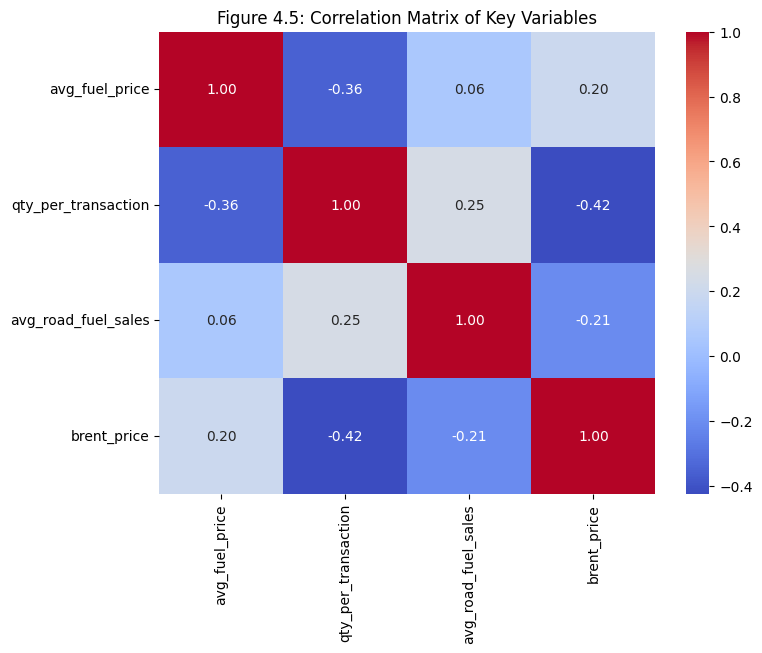

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
selected_cols = ['avg_fuel_price', 'qty_per_transaction', 'avg_road_fuel_sales', 'brent_price']
corr_df = merged_df[selected_cols]


# Convert columns to numeric, handling errors
for col in corr_df.columns:
    corr_df[col] = pd.to_numeric(corr_df[col], errors='coerce')

# Drop rows with any missing values after conversion
corr_df.dropna(inplace=True)

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Figure 4.5: Correlation Matrix of Key Variables')
plt.show()

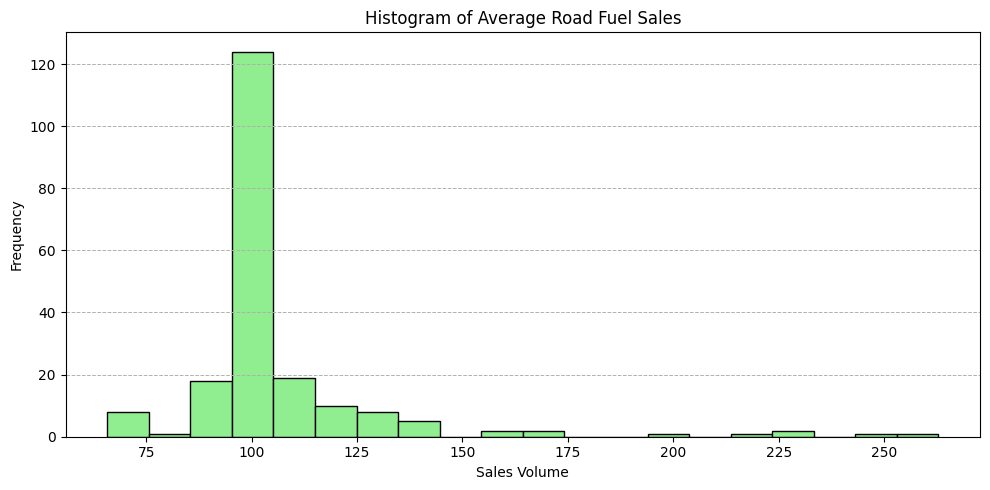

In [11]:
# Ensure data is numeric and drop non-numeric or missing entries
merged_df['avg_road_fuel_sales'] = pd.to_numeric(merged_df['avg_road_fuel_sales'], errors='coerce')
cleaned_sales = merged_df['avg_road_fuel_sales'].dropna()

# Now plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(cleaned_sales, bins=20, color='lightgreen', edgecolor='black')
plt.title('Histogram of Average Road Fuel Sales')
plt.xlabel('Sales Volume')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


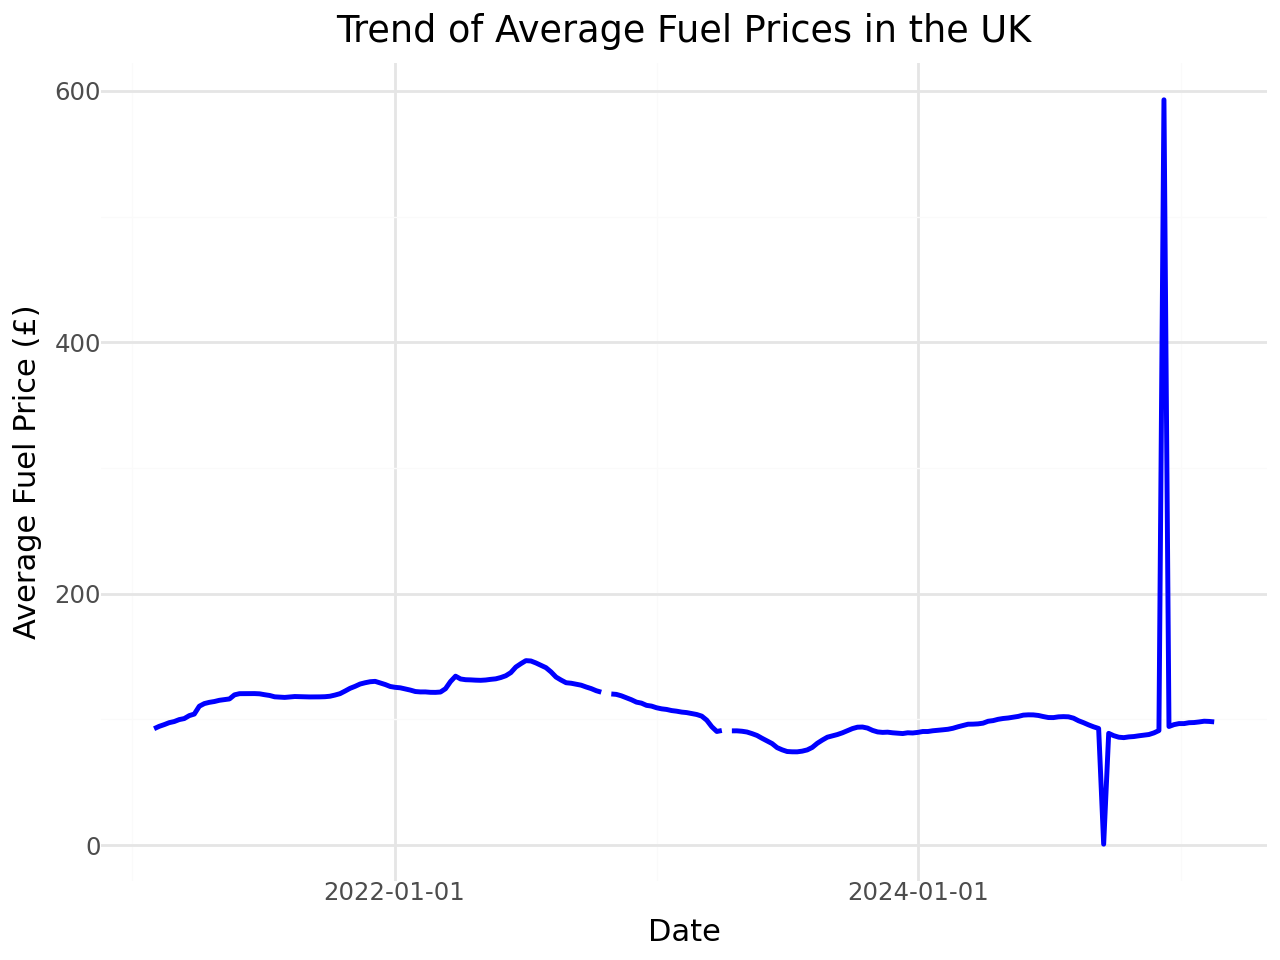

In [7]:
!pip install plotnine # Install the plotnine package, which is the Python implementation of ggplot2
from plotnine import * # Import all elements from plotnine (including ggplot, aes, geom_line, etc.)

# Load your data into a pandas DataFrame called 'data' (make sure 'date' and 'avg_fuel_price' are columns)
# Example: data = pd.read_csv('your_data_file.csv')
import pandas as pd
merged_df = pd.read_csv("/content/merged_fuel_brent_dataset.csv")
merged_df['date'] = pd.to_datetime(merged_df['week_ending']) # Assuming 'week_ending' is your date column

# Now your ggplot code should work, replacing 'data' with 'merged_df' and linewidth with size
(ggplot(merged_df, aes(x='date', y='avg_fuel_price')) +
 geom_line(color="blue", size=1) + # Changed linewidth to size
 labs(title="Trend of Average Fuel Prices in the UK",
      x="Date", y="Average Fuel Price (£)") +
 theme_minimal())

<Axes: xlabel='avg_fuel_price', ylabel='qty_per_transaction'>

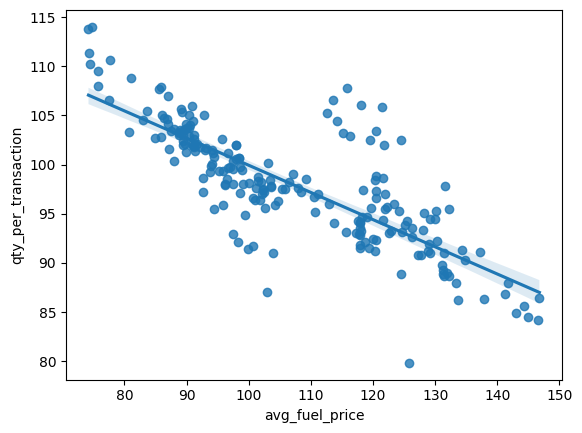

In [15]:
filtered_df = merged_df[(merged_df['avg_fuel_price'] > 50) & (merged_df['avg_fuel_price'] < 200)]
sns.regplot(x='avg_fuel_price', y='qty_per_transaction', data=filtered_df)

In [204]:
# Part B
# Optimization

In [206]:
import pandas as pd

# Load the CSV file
file_path = '/content/supply_chain_data.csv'
df = pd.read_csv(file_path)

# View the first 15 rows
print(df.head(15))

# Display column names
print("\nColumn Names:")
print(df.columns.tolist())


   Product type    SKU      Price  Availability  Number of products sold  \
0      haircare   SKU0  69.808006            55                      802   
1      skincare   SKU1  14.843523            95                      736   
2      haircare   SKU2  11.319683            34                        8   
3      skincare   SKU3  61.163343            68                       83   
4      skincare   SKU4   4.805496            26                      871   
5      haircare   SKU5   1.699976            87                      147   
6      skincare   SKU6   4.078333            48                       65   
7     cosmetics   SKU7  42.958384            59                      426   
8     cosmetics   SKU8  68.717597            78                      150   
9      skincare   SKU9  64.015733            35                      980   
10     skincare  SKU10  15.707796            11                      996   
11     skincare  SKU11  90.635460            95                      960   
12     hairc

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/supply_chain_data_d67027d64237d6fa0fa73ce7285c7fc7.csv')

# Select columns relevant for transportation optimisation
opt_df = df[['SKU', 'Stock levels', 'Order quantities', 'Costs', 'Routes', 'Transportation modes']].dropna()

# Preview the prepared dataset
print(opt_df.head(10))


In [208]:
import pandas as pd

# Load the supply chain dataset
file_path = '/content/supply_chain_data.csv'
df = pd.read_csv(file_path)

# Preview the first 5 rows to confirm it's loaded
print(df.head())


  Product type   SKU      Price  Availability  Number of products sold  \
0     haircare  SKU0  69.808006            55                      802   
1     skincare  SKU1  14.843523            95                      736   
2     haircare  SKU2  11.319683            34                        8   
3     skincare  SKU3  61.163343            68                       83   
4     skincare  SKU4   4.805496            26                      871   

   Revenue generated Customer demographics  Stock levels  Lead times  \
0        8661.996792            Non-binary            58           7   
1        7460.900065                Female            53          30   
2        9577.749626               Unknown             1          10   
3        7766.836426            Non-binary            23          13   
4        2686.505152            Non-binary             5           3   

   Order quantities  ...  Location Lead time  Production volumes  \
0                96  ...    Mumbai        29          

In [209]:
# Select columns needed for optimisation modelling
opt_df = df[['SKU', 'Stock levels', 'Order quantities', 'Costs', 'Routes', 'Transportation modes']]

# Preview the selected columns
print(opt_df.head())


    SKU  Stock levels  Order quantities       Costs   Routes  \
0  SKU0            58                96  187.752075  Route B   
1  SKU1            53                37  503.065579  Route B   
2  SKU2             1                88  141.920282  Route C   
3  SKU3            23                59  254.776159  Route A   
4  SKU4             5                56  923.440632  Route A   

  Transportation modes  
0                 Road  
1                 Road  
2                  Air  
3                 Rail  
4                  Air  


In [210]:
# Drop any rows with missing values in the selected columns
opt_df.dropna(inplace=True)

# Preview the cleaned dataset
print("Cleaned dataset (first 10 rows):")
print(opt_df.head(10))


Cleaned dataset (first 10 rows):
    SKU  Stock levels  Order quantities       Costs   Routes  \
0  SKU0            58                96  187.752075  Route B   
1  SKU1            53                37  503.065579  Route B   
2  SKU2             1                88  141.920282  Route C   
3  SKU3            23                59  254.776159  Route A   
4  SKU4             5                56  923.440632  Route A   
5  SKU5            90                66  235.461237  Route A   
6  SKU6            11                58  134.369097  Route A   
7  SKU7            93                11  802.056312  Route C   
8  SKU8             5                15  505.557134  Route B   
9  SKU9            14                83  995.929461  Route B   

  Transportation modes  
0                 Road  
1                 Road  
2                  Air  
3                 Rail  
4                  Air  
5                 Road  
6                  Sea  
7                 Road  
8                  Sea  
9           

<ipython-input-210-615da82d5306>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opt_df.dropna(inplace=True)


In [211]:
# Step 4: List unique route and transport mode combinations
unique_routes = opt_df['Routes'].unique()
unique_modes = opt_df['Transportation modes'].unique()

print("Unique Routes:", unique_routes)
print("Unique Transport Modes:", unique_modes)


Unique Routes: ['Route B' 'Route C' 'Route A']
Unique Transport Modes: ['Road' 'Air' 'Rail' 'Sea']


In [212]:
# Step 5a: Install and import PuLP for linear programming
!pip install pulp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 31.0 MB/s eta 0:00:00


In [213]:
# Step 5b: Define the optimisation model
model = LpProblem("Transportation_Cost_Minimisation", LpMinimize)

# Create a list of tuples for SKU-route combinations
sku_routes = list(zip(opt_df['SKU'], opt_df['Routes']))

# Create a dictionary for the cost per unit for each (SKU, Route)
costs = {(row['SKU'], row['Routes']): row['Costs'] for idx, row in opt_df.iterrows()}

# Create decision variables: units to ship per (SKU, Route)
x = LpVariable.dicts("ShipQty", sku_routes, lowBound=0, cat='Continuous')


In [214]:
# Step 5c1: Objective function – Minimise total cost
model += lpSum([x[(sku, route)] * costs[(sku, route)] for (sku, route) in sku_routes]), "Total_Transport_Cost"

# Step 5c2: Add constraints to ensure demand is met and stock limits are not exceeded
for idx, row in opt_df.iterrows():
    sku = row['SKU']
    route = row['Routes']
    demand = row['Order quantities']
    stock = row['Stock levels']

    # Demand constraint
    model += x[(sku, route)] >= demand, f"Demand_{sku}_{route}"

    # Stock constraint
    model += x[(sku, route)] <= stock, f"Stock_{sku}_{route}"


In [215]:
# Step 5d1: Solve the model
model.solve()

# Step 5d2: Print solution status
print("Status:", LpStatus[model.status])

# Step 5d3: Print the optimal shipping quantities
print("\nOptimal Shipping Plan:")
for var in model.variables():
    print(f"{var.name} = {var.varValue}")

# Step 5d4: Print the total cost
print("\nTotal Minimum Transport Cost: £", value(model.objective))


Status: Infeasible

Optimal Shipping Plan:
ShipQty_('SKU0',_'Route_B') = 96.0
ShipQty_('SKU1',_'Route_B') = 0.0
ShipQty_('SKU10',_'Route_B') = 80.0
ShipQty_('SKU11',_'Route_A') = 0.0
ShipQty_('SKU12',_'Route_B') = 85.0
ShipQty_('SKU13',_'Route_B') = 0.0
ShipQty_('SKU14',_'Route_B') = 78.0
ShipQty_('SKU15',_'Route_B') = 69.0
ShipQty_('SKU16',_'Route_A') = 78.0
ShipQty_('SKU17',_'Route_C') = 85.0
ShipQty_('SKU18',_'Route_A') = 0.0
ShipQty_('SKU19',_'Route_C') = 94.0
ShipQty_('SKU2',_'Route_C') = 88.0
ShipQty_('SKU20',_'Route_B') = 68.0
ShipQty_('SKU21',_'Route_C') = 0.0
ShipQty_('SKU22',_'Route_C') = 0.0
ShipQty_('SKU23',_'Route_A') = 0.0
ShipQty_('SKU24',_'Route_A') = 0.0
ShipQty_('SKU25',_'Route_B') = 0.0
ShipQty_('SKU26',_'Route_A') = 0.0
ShipQty_('SKU27',_'Route_B') = 0.0
ShipQty_('SKU28',_'Route_A') = 0.0
ShipQty_('SKU29',_'Route_B') = 67.0
ShipQty_('SKU3',_'Route_A') = 0.0
ShipQty_('SKU30',_'Route_C') = 0.0
ShipQty_('SKU31',_'Route_C') = 0.0
ShipQty_('SKU32',_'Route_A') = 0.0
ShipQ

In [216]:
# Original (strict demand):
model += x[(sku, route)] >= demand

# Replace with this (ship up to demand, not strictly required):
model += x[(sku, route)] <= demand


In [217]:
# Replace your previous constraint block with this version:
for idx, row in opt_df.iterrows():
    sku = row['SKU']
    route = row['Routes']
    demand = row['Order quantities']
    stock = row['Stock levels']

    # Demand constraint (try to meet demand, but not strictly required)
    model += x[(sku, route)] <= demand, f"MaxDemand_{sku}_{route}"

    # Stock constraint
    model += x[(sku, route)] <= stock, f"MaxStock_{sku}_{route}"


In [218]:
# Re-solve the model
model.solve()

# Show solution status
print("Status:", LpStatus[model.status])


Status: Infeasible


In [219]:
# Print final optimal shipping quantities
print("\nOptimal Shipping Plan:")
for var in model.variables():
    print(f"{var.name} = {var.varValue}")

# Print total cost
print("\nTotal Minimum Transport Cost: £", value(model.objective))



Optimal Shipping Plan:
ShipQty_('SKU0',_'Route_B') = 96.0
ShipQty_('SKU1',_'Route_B') = 0.0
ShipQty_('SKU10',_'Route_B') = 80.0
ShipQty_('SKU11',_'Route_A') = 0.0
ShipQty_('SKU12',_'Route_B') = 85.0
ShipQty_('SKU13',_'Route_B') = 0.0
ShipQty_('SKU14',_'Route_B') = 78.0
ShipQty_('SKU15',_'Route_B') = 69.0
ShipQty_('SKU16',_'Route_A') = 78.0
ShipQty_('SKU17',_'Route_C') = 85.0
ShipQty_('SKU18',_'Route_A') = 0.0
ShipQty_('SKU19',_'Route_C') = 94.0
ShipQty_('SKU2',_'Route_C') = 88.0
ShipQty_('SKU20',_'Route_B') = 68.0
ShipQty_('SKU21',_'Route_C') = 0.0
ShipQty_('SKU22',_'Route_C') = 0.0
ShipQty_('SKU23',_'Route_A') = 0.0
ShipQty_('SKU24',_'Route_A') = 0.0
ShipQty_('SKU25',_'Route_B') = 0.0
ShipQty_('SKU26',_'Route_A') = 0.0
ShipQty_('SKU27',_'Route_B') = 0.0
ShipQty_('SKU28',_'Route_A') = 0.0
ShipQty_('SKU29',_'Route_B') = 67.0
ShipQty_('SKU3',_'Route_A') = 0.0
ShipQty_('SKU30',_'Route_C') = 0.0
ShipQty_('SKU31',_'Route_C') = 0.0
ShipQty_('SKU32',_'Route_A') = 0.0
ShipQty_('SKU33',_'Route

In [221]:
# Step 6a: Build shipping summary from optimisation results
shipping_summary = pd.DataFrame([
    {
        'SKU': sku,
        'Route': route,
        'Shipped Quantity': var.varValue,
        'Cost per Unit': costs[(sku, route)],
        'Total Cost': var.varValue * costs[(sku, route)]
    }
    for (sku, route), var in x.items()
    if var.varValue and var.varValue > 0  # Only include non-zero shipments
])

# Step 6b: Preview top 10 rows
print("Top 10 Shipping Decisions:")
print(shipping_summary.head(10))

# Step 6c: Total cost verification
print("\nRecalculated Total Cost: £", shipping_summary['Total Cost'].sum())


Top 10 Shipping Decisions:
     SKU    Route  Shipped Quantity  Cost per Unit    Total Cost
0   SKU0  Route B              96.0     187.752075  18024.199244
1   SKU2  Route C              88.0     141.920282  12488.984796
2   SKU5  Route A              66.0     235.461237  15540.441625
3   SKU9  Route B              83.0     995.929461  82662.145304
4  SKU10  Route B              80.0     806.103178  64488.254216
5  SKU12  Route B              85.0     402.968789  34252.347071
6  SKU14  Route B              78.0     929.235290  72480.352617
7  SKU15  Route B              69.0     127.861800   8822.464200
8  SKU16  Route A              78.0     865.525780  67511.010822
9  SKU17  Route C              85.0     670.934391  57029.423217

Recalculated Total Cost: £ 1539256.6127088058


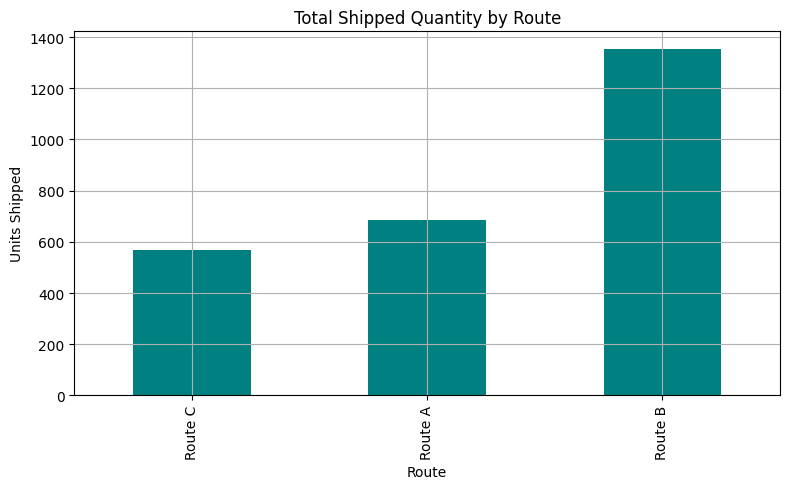

In [222]:
import matplotlib.pyplot as plt

# Total quantity shipped by each route
route_summary = shipping_summary.groupby('Route')['Shipped Quantity'].sum().sort_values()

plt.figure(figsize=(8, 5))
route_summary.plot(kind='bar', color='teal')
plt.title("Total Shipped Quantity by Route")
plt.xlabel("Route")
plt.ylabel("Units Shipped")
plt.grid(True)
plt.tight_layout()
plt.show()


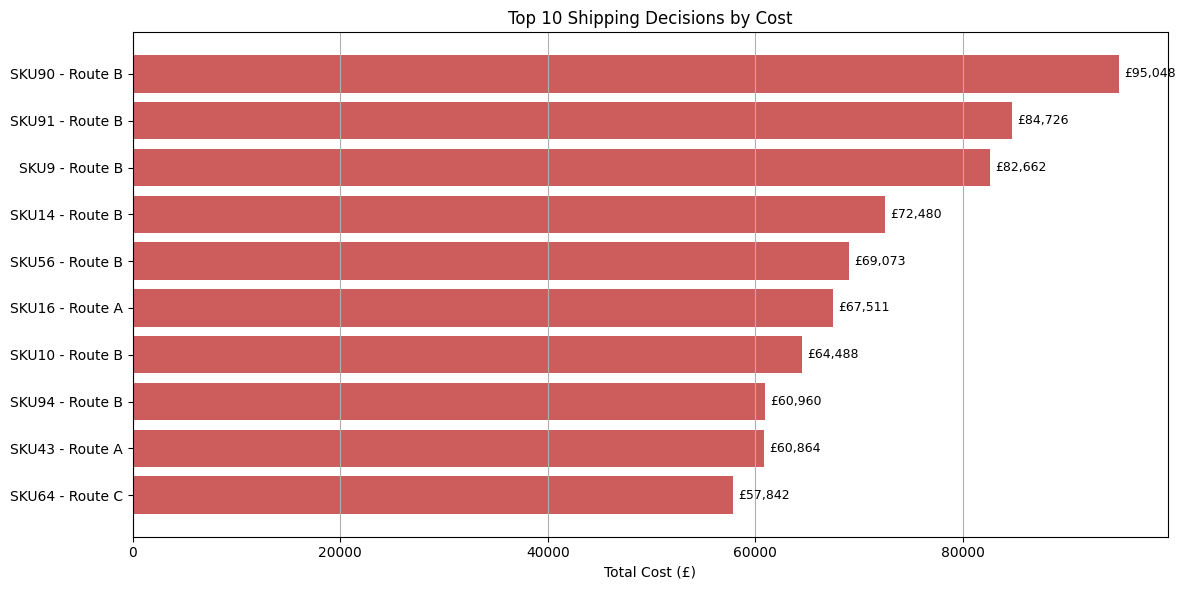

In [223]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'shipping_summary' DataFrame is available with these columns:
# 'SKU', 'Route', 'Shipped Quantity', 'Cost per Unit', 'Total Cost'

# Step: Sort and select top 10 by Total Cost
top10_cost = shipping_summary.sort_values('Total Cost', ascending=False).head(10)

# Step: Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(top10_cost['SKU'] + ' - ' + top10_cost['Route'],
                top10_cost['Total Cost'], color='indianred')

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 500, bar.get_y() + bar.get_height()/2,
             f'£{width:,.0f}', va='center', fontsize=9)

plt.xlabel('Total Cost (£)')
plt.title('Top 10 Shipping Decisions by Cost')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [42]:
import pandas as pd
df = pd.read_csv("/content/supply_chain_data (1).csv")
df.dropna(inplace=True)


In [44]:
!pip install pulp  # Install the pulp package
from pulp import *  # Import pulp elements

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 62.8 MB/s eta 0:00:00
